In [1]:
import time
import numpy as np
import math
import random
from scipy.spatial import distance

#topological data analysis
from ripser import ripser
from persim import plot_diagrams

#plotting and visualization
from plotly.subplots import make_subplots
from matplotlib.patches import Circle

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm

#manifold learning and dim red
from sklearn.decomposition import PCA

#topological data analysis

from dreimac import CircularCoords, CircleMapUtils, GeometryExamples, PlotUtils, ComplexProjectiveCoords, ProjectiveMapUtils, GeometryUtils

#plotting and visualization
from jupyter_dash import JupyterDash
from dash import Dash, dcc, html, Input, Output, no_update
import plotly.graph_objects as go
import pandas as pd
import base64

from PIL import Image

from numpy import linalg, matmul
from scipy import special

import plotly.express as px

In [2]:
# upload the excel files using pandas
# for the purposes of spherical harmonics approximation, 0s are appended as the 4th coordinate to the data
# this does not change the persistent cohomology e.g. the distance between (1,1) and (2,2) is the same as (1,1,0) and (2,2,0)
shape1 = np.loadtxt('data/33.txt', delimiter=',')

print(shape1.shape)

(12500, 4)


In [19]:
fig = go.Figure(data=[go.Scatter3d(
    x=shape1[:,0], y=shape1[:,1], z=shape1[:,2], 
    mode ='markers', 
    marker=dict(size = 3, color =shape1[:,0], colorscale='plasma' , opacity = 1)
)])

fig.update_layout(autosize=False, width=700, height=700)  
fig.show()

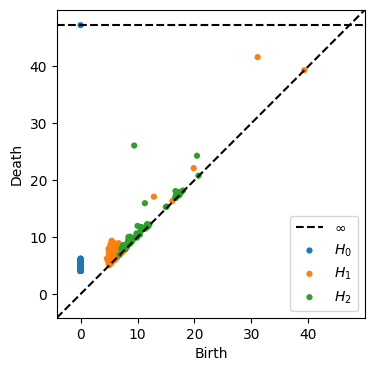

In [5]:
#ripser persistent cohomology analysis
n_land = 700
res = ripser(shape1, n_perm = n_land, maxdim=2, coeff =13)
dgms = res['dgms']
plt.figure(figsize = (4,4))
plot_diagrams(dgms)

In [6]:
pers1 = dgms[1][:,1] - dgms[1][:,0]
pers2 = dgms[2][:,1] - dgms[2][:,0]

pers1_sorted = np.sort(pers1)[::-1]
pers2_sorted = np.sort(pers2[pers2 < np.Inf])[::-1]
print('Object 33')
print('Persistence of top 10 1-d features:\n', np.around(pers1_sorted[0:10],decimals=2), '\n')
print('Persistence of top 10 2-d features:\n', np.around(pers2_sorted[0:10],decimals=2))

Object 33
Persistence of top 10 1-d features:
 [10.52  4.22  3.91  3.68  3.52  3.36  3.15  3.09  3.06  3.04] 

Persistence of top 10 2-d features:
 [16.67  4.66  3.85  1.97  1.62  1.43  1.37  1.25  1.18  1.12]


In [8]:
#running persistence using geodesic distance
dist_mat, pointcloud_permutation = GeometryUtils.landmark_geodesic_distance(shape1, 500, 20)

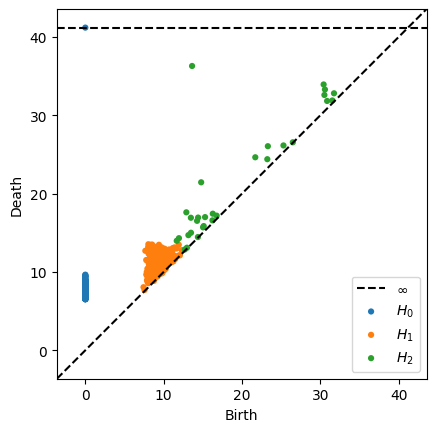

In [9]:
cpc = ComplexProjectiveCoords(dist_mat, n_landmarks=300, distance_matrix=True)
fig = plt.figure()
plot_diagrams(cpc.dgms_)
#peristence of 2d features is much better

In [10]:
coords = cpc.get_coordinates(perc=0.9, proj_dim=1)
coords_R3 = ProjectiveMapUtils.hopf_map(coords)
coords_R2 = ProjectiveMapUtils.stereographic_projection_hemispheres(coords_R3)

In [17]:
fig = go.Figure(data=[go.Scatter3d(
    x=coords_R3[:,0], y=coords_R3[:,1], z=coords_R3[:,2], 
    mode ='markers', 
    marker=dict(size = 3, color =coords_R3[:,0], colorscale='plasma' , opacity = 1)
)])

fig.update_layout(autosize=False, width=700, height=700)  
fig.show()

In [21]:
# converting R3 coordinates to spherical coordinates

def angle_from_side(a, b, c):#law of cosines for sides a,b,c returning angle C
    
    cos_c = (a **2 + b ** 2 - c ** 2)/(2*a*b)
    C = math.acos(cos_c)
    return C

sphericalcoords = []
for i in coords_R3:
    r = math.sqrt((i[0])**2 + (i[1])**2 + (i[2])**2)
    w = math.sqrt((-i[0])**2 + (i[1])**2)
    theta = math.acos((i[2])/r)
    phi = angle_from_side(i[0], i[1], w)
    sphericalcoords.append([r, theta, phi])

In [36]:
D = shape1.shape[0]
N = 85
A = []

for i in range(D):
    for j in range(N):
        A.append(special.sph_harm(j+1, N, sphericalcoords[i][1], sphericalcoords[i][2]))
A = np.array(A)
A = A.reshape(D,N)

In [37]:
# Creating the local inverse via use of the Moore-Penrose pseudoinverse
A_inv = linalg.pinv(A)
u = matmul(A_inv, sphericalcoords)

In [38]:
error = (linalg.norm(sphericalcoords - matmul(A, u)))
error = error/shape1.shape[0]
print(error)

0.007740723255722869


In [40]:
start_time = time.time()
error_param = []

for param in range(100):
    mat = []
    for row in range(param):
        for col in range(row+1):
            if col == 0 :
                mat.append((row, col))
            else:
                mat.append((row, col))
                mat.append((row, -1*col))
    func = mat[:param]
    
    A = []
    for i in range(D):
        for ind in func:
            A.append(special.sph_harm(j+1, N, sphericalcoords[i][1], sphericalcoords[i][2]))
    A = np.array(A)
    A = A.reshape(D,param)
    A_inv = linalg.pinv(A)
    u = matmul(A_inv, sphericalcoords)
    error = (linalg.norm(sphericalcoords - matmul(A, u)))
    error = error/shape1.shape[0]
    error_param.append(error)

end_time = time.time()
print(end_time - start_time)

249.47641110420227


Text(0, 0.5, 'Average Error')

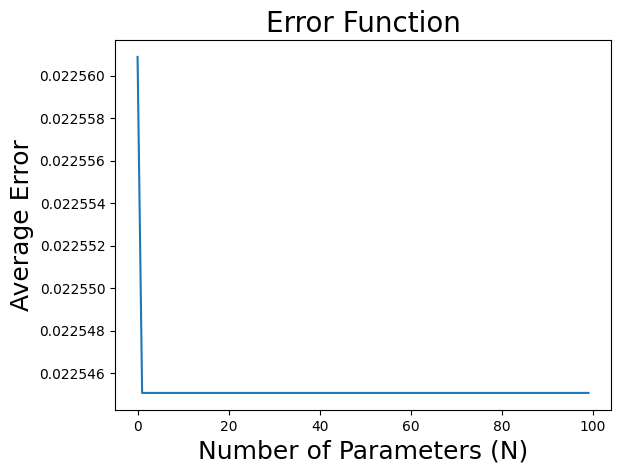

In [41]:
plt.plot(range(100), error_param)
plt.title("Error Function", fontsize=20)
plt.xlabel("Number of Parameters (N)", fontsize=18)
plt.ylabel("Average Error", fontsize=18)